In [ ]:
!pip install natsort

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import time
import torch
import copy, re
import natsort
from PIL import Image
import pandas as pd
from collections import Counter
from tqdm.notebook import trange, tqdm
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image, ImageReadMode
# from easyfsl.samplers import TaskSampler
# from easyfsl.utils import plot_images, sliding_average
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.manifold import TSNE


In [3]:
class Human_Wound_Dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform 
        # self.labels_csv = pd.read_csv('/content/gdrive/MyDrive/HealNet/Healer vs. Non Healer/Few_Shot_Learning_Data/Human_Labels_Final.csv')
        self.samples, self.targets, self.patientID = self.make_dataset(self.root_dir)
   
    def make_dataset(self, root_dir):
        image_list = os.listdir(root_dir)
        # image_list.sort(key=lambda f: int(re.sub('\D', '', f)))
        image_list = natsort.natsorted(image_list)
        # print(image_list)

        final_data_list = []


        patient_ID_list = []
        cls_counter = {}
        day_counter = 0
        dataset_list = []
        clss_list_encoded = []

        for image_name in image_list:
            final_data_list.append(root_dir + image_name)
            patiendID, day, cls = image_name.split("_")
            patient_ID_list.append(int(patiendID[7:]))
            cls = cls[:-4]
            if cls == 'Healer':
                clss_list_encoded.append(1)
            else:
                clss_list_encoded.append(0)
        # print(final_data_list)
        return final_data_list, clss_list_encoded, patient_ID_list

    def pil_loader(self, path):
        # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
        print(path)
        img = Image.open(path)
        img = img.convert('RGB')
        img = img.resize((224,224), Image.BICUBIC)
        return img
    def __getitem__(self, index: int):
        """
        Returns tensor data and label.
        Args:
            index (int): Index
        Returns:
            tuple: (sample, target) where sample is a tensor of input data
                    target is class of sample.
        """
        # Get images and targets, drop alpha
        img_path = self.samples[index]
        img = self.pil_loader(img_path)

        if self.transform:
            img = self.transform(img)
        target = self.targets[index]
        patientID = self.patientID[index]

        return img, target, patientID

    def __len__(self):
        return len(self.samples)

In [4]:
human = Human_Wound_Dataset('/content/drive/MyDrive/HealNet/Healer vs. Non Healer/Few_Shot_Learning_Data/All_Patients_Final/')

In [5]:
def wound_collate(batch):
    # Form a tensor of first tuple items in batch
    data = torch.stack([item[0] for item in batch])  
    # Tensorize targets
    target = [item[1] for item in batch]
    target = torch.LongTensor(target)
    patiendID = [item[2] for item in batch]
    patiendID = torch.LongTensor(patiendID)
    # Return tuple of data & targets
    return [data, target, patiendID]

In [6]:
def wound_dataloader(dataset, batch_size: int, num_workers = 0, shuffle = False, pin_memory = False):
    return DataLoader(
        dataset,
        batch_size=batch_size,
        collate_fn=wound_collate,
        num_workers=num_workers,
        shuffle = shuffle,
        pin_memory = pin_memory)

In [7]:
input_size = 224 # Muse be 224 (3x224x224) for Densenet121

# Standard Pytorch image transforms (source:https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html)
data_transforms = transforms.Compose([
        # transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [8]:
class Encoder(nn.Module):
    """
    Encoder model Pytorch. 
    """   
    def __init__(self):
        # Initialize self._modules as OrderedDict
        super(Encoder, self).__init__() 
        # Initialize densenet121
        self.embed_model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=False)
        # Remove Classifying layer
        self.embed_model = nn.Sequential(*list(self.embed_model.children())[:-1])
        # 7x7 average pool layer
        self.avg = nn.AvgPool2d(kernel_size=7, stride=1)
        # Left image connected layers
        self.fc_16 = nn.Linear(1024, 16)


    def forward(self, x):
        # Embed Left
        u1 = self.embed_model(x)
        u1 = self.avg(u1)
        u1 = u1.view(-1,1024)
        u1 = self.fc_16(u1)
        #u1 = torch.relu(u1)
        return u1

    def load_embed_wts(self, device):
        """
        load pretrained model weights, use only when transfer learning from ImageNET data
        """
        # Initialize densenet121
        self.embed_model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True).to(device)

        # Remove Classifying layer
        self.embed_model = nn.Sequential(*list(self.embed_model.children())[:-1])

class Projection(nn.Module):
    """
    Creates projection head
    Args:
        n_in (int): Number of input features
        n_hidden (int): Number of hidden features
        n_out (int): Number of output features
        use_bn (bool): Whether to use batch norm
    """
    def __init__(self, n_in: int, n_hidden: int, n_out: int,
                use_bn: bool = True):
        super().__init__()
        
        # No point in using bias if we've batch norm
        self.lin1 = nn.Linear(1024, 1024, bias = True)
        self.bn = nn.BatchNorm1d(1024)
        self.relu = nn.ReLU()
        # No bias for the final linear layer
        self.lin2 = nn.Linear(1024, 128, bias=False)
    
    def forward(self, x):
        x = self.lin1(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.lin2(x)
        return x

class SupConClassifier(nn.Module):
    def __init__(self, projection_n_in: int = 16,
               projection_n_hidden: int = 16, projection_n_out: int = 16,
               projection_use_bn: bool = True):
        super().__init__()
        
        # self.encoder = Encoder()
        self.pre_encoder = Encoder()
        self.encoder = nn.Sequential(*list(self.pre_encoder.children())[:-1])

        for param in self.encoder.parameters():
            param.requires_grad = False
        self.projection = Projection(projection_n_in, projection_n_hidden,
                                    projection_n_out, projection_use_bn)
  
    def forward(self, x):
        x = self.encoder(x)
        x = x.view(-1,1024)
        x = self.projection(x)
        return x

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.selfsup = SupConClassifier()
        self.middle = nn.Linear(128,32)
        # self.relu = nn.ReLU()
        # self.classifier = nn.Linear(4,2)

    def forward(self, x):
        x = self. selfsup(x)
        x = self. middle(x)
        # x = self. middle(x)
        # x = self.classifier(x)

        return x

In [9]:
def train_model(model, dataloader):
    model.eval()
    image_ftr_encodings = []
    image_ftr_labels = []
    patiend_id_list = []
    length = len(dataloader)
    for image, image_label, patiendID in dataloader:
        image_ftr = model(image)
        image_ftr_encodings.append(image_ftr.cpu().detach().numpy())
        image_ftr_labels.extend(image_label.cpu().detach().numpy().tolist())
        patiend_id_list.extend(patiendID.cpu().detach().numpy().tolist())
        del image_ftr
    image_ftr_encodings = np.array(image_ftr_encodings)
    print(image_ftr_encodings.shape)
    image_ftr_encodings = np.reshape(image_ftr_encodings, (length, 128))
    return image_ftr_encodings, image_ftr_labels, patiend_id_list

In [10]:
sequence_length = 4
fewshot = SupConClassifier()
fewshot.to('cpu')
path = '/content/drive/MyDrive/HealNet/Healer vs. Non Healer/Few_Shot_Learning_Data/All_Patients_Final/'

# fewshot.load_encoder_wts(device)
# path_to_encoder = '/content/drive/MyDrive/HealNet/Healer vs. Non Healer/Weights/meta_learned_ENCODER.tar'
path_to_encoder = "/content/drive/MyDrive/HealNet/Healer vs. Non Healer/Weights/Contrastive_Encoder_June_20" # Path to healnet weights
fewshot.load_state_dict(torch.load(path_to_encoder, map_location='cpu'))
data_path = '/content/drive/MyDrive/HealNet/Healer vs. Non Healer/Few_Shot_Learning_Data'
batch_size = 1
data_loader = wound_dataloader(Human_Wound_Dataset(path, transform=data_transforms), 
                                             batch_size, num_workers = 0, shuffle = False, pin_memory = True)

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip


In [11]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

# embed_model = nn.Sequential(*list(fewshot.children()))
count_parameters(fewshot)

+--------------------------+------------+
|         Modules          | Parameters |
+--------------------------+------------+
| pre_encoder.fc_16.weight |   16384    |
|  pre_encoder.fc_16.bias  |     16     |
|  projection.lin1.weight  |  1048576   |
|   projection.lin1.bias   |    1024    |
|   projection.bn.weight   |    1024    |
|    projection.bn.bias    |    1024    |
|  projection.lin2.weight  |   131072   |
+--------------------------+------------+
Total Trainable Params: 1199120


1199120

In [12]:
combined, combined_labels, combined_ids = train_model(fewshot, data_loader)

/content/drive/MyDrive/HealNet/Healer vs. Non Healer/Few_Shot_Learning_Data/All_Patients_Final/Patient0_Day0_Healer.png
/content/drive/MyDrive/HealNet/Healer vs. Non Healer/Few_Shot_Learning_Data/All_Patients_Final/Patient0_Day1_Healer.png
/content/drive/MyDrive/HealNet/Healer vs. Non Healer/Few_Shot_Learning_Data/All_Patients_Final/Patient0_Day2_Healer.png
/content/drive/MyDrive/HealNet/Healer vs. Non Healer/Few_Shot_Learning_Data/All_Patients_Final/Patient0_Day3_Healer.png
/content/drive/MyDrive/HealNet/Healer vs. Non Healer/Few_Shot_Learning_Data/All_Patients_Final/Patient0_Day4_Healer.png
/content/drive/MyDrive/HealNet/Healer vs. Non Healer/Few_Shot_Learning_Data/All_Patients_Final/Patient0_Day5_Healer.png
/content/drive/MyDrive/HealNet/Healer vs. Non Healer/Few_Shot_Learning_Data/All_Patients_Final/Patient1_Day0_NonHealer.png
/content/drive/MyDrive/HealNet/Healer vs. Non Healer/Few_Shot_Learning_Data/All_Patients_Final/Patient1_Day1_NonHealer.png
/content/drive/MyDrive/HealNet/Hea

In [22]:
def scale_to_01_range(x):
    value_range = (np.max(x) - np.min(x))
    starts_from_zero = x - np.min(x)
    return starts_from_zero / value_range

def get_cmap(n, name='rdb'):
    return plt.cm.get_cmap(name, n)
    
def plot_tsne(ftrs, labels, ids):

    tsne = TSNE().fit_transform(ftrs)
    tx = tsne[:, 0]
    ty = tsne[:, 1]
    tx = scale_to_01_range(tx)
    ty = scale_to_01_range(ty)

    data_fr = pd.DataFrame(columns = ['Frt_1', 'Frt_2', 'Class_label', 'PatientID'])

    data_fr['Frt_1'] = tx
    data_fr['Frt_2'] = ty
    data_fr['Class_label'] = labels
    data_fr['PatientID'] = ids

    sns.set(rc={'figure.figsize':(15,15)})
    clrs = sns.color_palette("husl", n_colors = 2)
    sns.scatterplot(data=data_fr, x="Frt_1", y="Frt_2", hue="Class_label", style="Class_label", legend='full', s=75, palette = clrs)

    # clrs = sns.color_palette("husl", n_colors = 20)
    # sns.scatterplot(data=data_fr, x="Frt_1", y="Frt_2", hue="PatientID", style="Class_label", legend='full', s=75, palette = clrs)



 

In [17]:
# combined

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


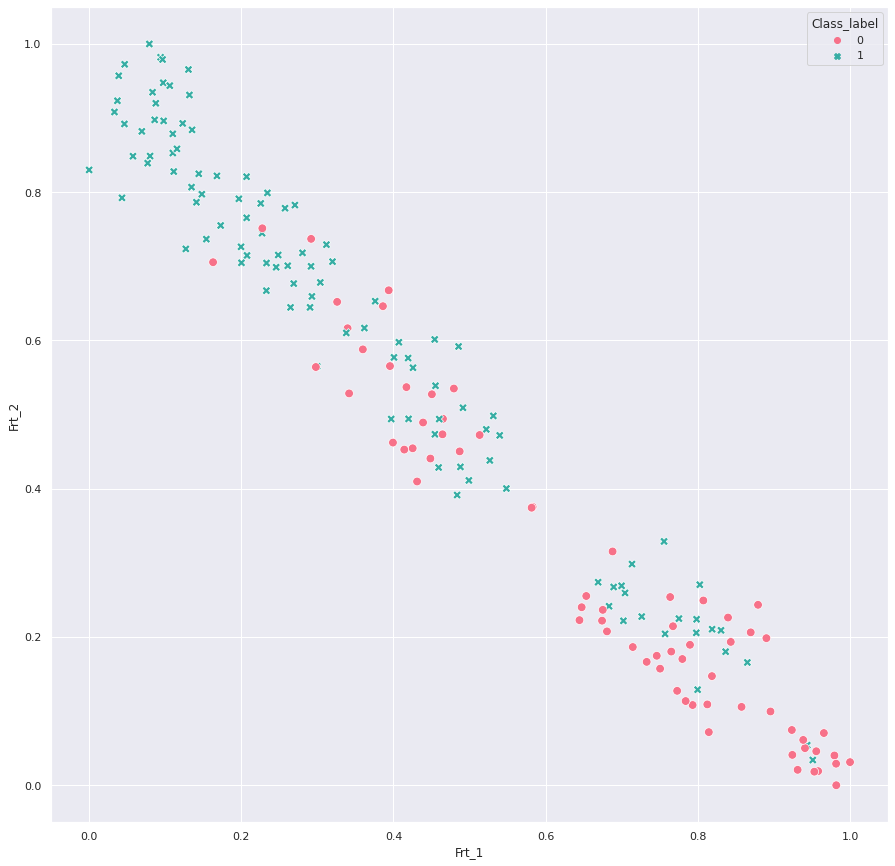

In [23]:
plot_tsne(combined, combined_labels, combined_ids)

In [ ]:
# from sklearn import decomposition
# from sklearn import datasets
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

In [ ]:
# pca = decomposition.PCA(n_components=2)
# pca.fit(combined)
# X = pca.transform(combined)
# df = pd.DataFrame(X,columns=['pca-one', 'pca-two'])
# df['y'] = np.array(combined_labels).flatten()
# print(df)
# plt.figure(figsize=(10,10));
# sns.scatterplot(
#     x="pca-one", y="pca-two",
#     hue="y",
#     palette=sns.color_palette("hls", 2),
#     data=df,
#     legend="full",
#     alpha=0.9
# )